<a href="https://colab.research.google.com/github/marioschlosser/adventure-game-graph/blob/main/Custom_GPT_Adventure_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy

# @title Configure the adventure game graph

# the max number of in-links for a node from new nodes
max_in_new = 3 # @param {type:"integer"}

# the max number of in-links for a node from existing nodes
max_in_existing = 2 # @param {type:"integer"}

# the base number of nodes in the graph
num_nodes = 5 # @param {type:"integer"}

# the number of initially accessible rooms
num_rooms_initial = 3 # @param {type:"integer"}

# the number of rooms in total
num_rooms_total = 5 # @param {type:"integer"}

def add_ancestor(node, ancestor):
    # add ancestor to node's list of ancestors, but only if it isn't already in the list
    if ancestor not in node_ancestors[node]:
        node_ancestors[node].append(ancestor)

    # compile list of out-links for this node: this is the list of nodes for which node is an in-link
    node_out = []
    for other_node in range(0, len(node_in)):
        if node in node_in[other_node]:
            node_out.append(other_node)

    # call add_ancestor for all out-links of this node
    for other_node in node_out:
        add_ancestor(other_node, ancestor)

In [15]:
# @title Initialize the puzzle graph generator

# the in-links for each node: the set of nodes that directly drive this node
node_in = [[]]
# the ancestors of each node: the set of nodes that directly and indirectly drive this node
node_ancestors = [[]]
# the room that each node is in
node_room = [0]
# the set of nodes that are rooms
rooms = []

In [16]:
# @title Create the puzzle graph

for node in range(0, num_nodes):
    # generate a random number of in-links for this new node from new nodes
    num_new_in = random.randint(1, max_in_new)
    # generate a random number of in-links for this node from existing nodes
    num_existing_in = random.randint(0, max_in_existing)

    # create range of numbers: node to node + num_new_in to new_in
    new_in = list(range(len(node_in), len(node_in) + num_new_in))

    # create the in-links lists for num_new_in nodes
    for i in range(0, num_new_in):
        node_in.append([])
        node_ancestors.append([])
        node_room.append(None)

    # add that list to the current node's in-links
    node_in[node] = new_in

    # create empty list of ancestors for this node
    node_ancestors[node] = []

    # update ancestors for this node recursively
    add_ancestor(node, node)

    # generate list of all existing nodes where node isn't an ancestor
    existing_nodes = []
    for i in range(0, node):
        if node not in node_ancestors[i]:
            existing_nodes.append(i)

    # pick num_existing_in nodes from that list randomly
    existing_in = random.sample(existing_nodes, min(num_existing_in, len(existing_nodes)))

    # add that list to the current node's in-links
    node_in[node] += existing_in

In [17]:
# show the graph
print("Here is the graph without rooms:")
print(node_in)

Here is the graph without rooms:
[[1], [2, 3, 4], [5], [6, 7, 8], [9, 2], [], [], [], [], []]


In [18]:
# @title Add the initially accessible rooms to the game

# create list of non-leaf nodes
non_leaf_nodes = [i for i, sublist in enumerate(node_in) if sublist]

# get the list of leaf nodes: all remaining rooms
leaf_nodes = [element for element in range(0, len(node_in)) if element not in non_leaf_nodes]

# average number of leaf nodes connected to an initial room, rounded up
avg_leaf_nodes_per_room = int(np.ceil(len(leaf_nodes) / num_rooms_initial))

# create the initial rooms and add them to the graph
for i in range(0, num_rooms_initial):
    # create new node
    node_in.append([])
    node_ancestors.append([])
    node_room.append(None)
    room = len(node_in) - 1

    # this node is a room, so its room is just itself
    node_room[room] = room

    # add to the list of rooms
    rooms.append(room)

# go through the leaf nodes and add them to the initial rooms randomly
for leaf_node in leaf_nodes:
    # pick a random initial room
    room = random.choice(rooms)

    # add the leaf node to the room
    node_in[leaf_node].append(room)
    add_ancestor(leaf_node, room)

In [19]:
# @title Add the rooms that unlock during the game

# the number of rooms to unlock during the game
num_unlocked_rooms = num_rooms_total - num_rooms_initial

# pick this number of non-leaf nodes and make them rooms
for i in range(0, num_unlocked_rooms):
    # pick a random non-leaf node
    room = random.choice(non_leaf_nodes)

    # add the room to the list of rooms
    rooms.append(room)

    # this node is a room, so its room is just itself
    node_room[room] = room

    # remove the room from the list of non-leaf nodes
    non_leaf_nodes.remove(room)

In [20]:
# @title Link all puzzle nodes to rooms

# set all puzzle nodes to rooms
for node in range(0, len(node_in)):
    # skip nodes that are already rooms
    if node in rooms:
        continue

    # pick a room node that is in this node's ancestors
    room = random.choice([ancestor for ancestor in node_ancestors[node] if ancestor in rooms])
    # set this as this node's room
    node_room[node] = room

In [21]:
print("Here is the graph with rooms:")
print(node_in)
print("Here are the room nodes:")
print(rooms)
print("Here is the room for each node:")
print(node_room)

# non_rooms is the set of nodes that are not rooms
non_rooms = [node for node in range(len(node_in)) if node not in rooms]

# create the node names
node_name = {node: "Room " + chr(ord('A') + rooms.index(node)) if node in rooms else "Action " + str(len(non_rooms) - non_rooms.index(node)) for node in range(len(node_in))}
# set the name for the final node
node_name[0] = "Game End"

Here is the graph with rooms:
[[1], [2, 3, 4], [5], [6, 7, 8], [9, 2], [12], [12], [10], [11], [11], [], [], []]
Here are the room nodes:
[10, 11, 12, 1, 3]
Here is the room for each node:
[3, 1, 12, 3, 11, 12, 12, 10, 11, 11, 10, 11, 12]


In [22]:
# @title Print out the adventure game graph

for node in range(len(node_in)):
    # create list of all in-link names for this node
    node_in_names = []
    for other_node in node_in[node]:
        # only append non-rooms for conditions
        if other_node in non_rooms:
            node_in_names.append(node_name[other_node])

    required = ", ".join(node_in_names)
    required = "nothing" if required == "" else "unlocking " + required

    if node in non_rooms:
        print(f"{node_name[node]} is available in {node_name[node_room[node]]} and requires", required)
    else:
        print(f"{node_name[node]} requires", required)

Game End is available in Room E and requires nothing
Room D requires unlocking Action 7, Action 6
Action 7 is available in Room C and requires unlocking Action 5
Room E requires unlocking Action 4, Action 3, Action 2
Action 6 is available in Room B and requires unlocking Action 1, Action 7
Action 5 is available in Room C and requires nothing
Action 4 is available in Room C and requires nothing
Action 3 is available in Room A and requires nothing
Action 2 is available in Room B and requires nothing
Action 1 is available in Room B and requires nothing
Room A requires nothing
Room B requires nothing
Room C requires nothing


Rooms are circles, puzzles are squares. The color of each node is the node's associated room (for puzzles: which rooms they take place in).


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


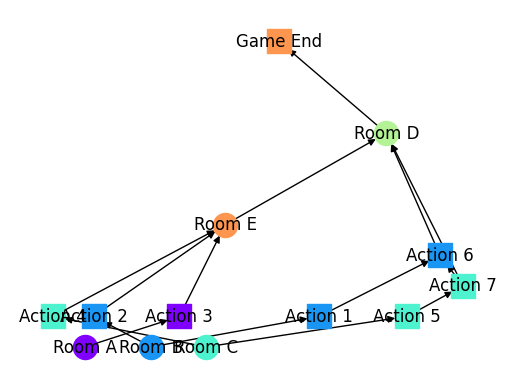

In [23]:
# @title Visualize the adventure game graph

def draw_network(G, pos, node_color, node_shape, node_name):
    fig, ax = plt.subplots()

    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax)

    # Draw nodes with specified shapes and colors
    for (node, color), (node, shape) in zip(node_color.items(), node_shape.items()):
        # if node is a room, draw it as a square
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_shape=shape, ax=ax)

    # Draw custom labels
    nx.draw_networkx_labels(G, pos, labels=node_name, ax=ax)

    plt.axis('off')
    plt.show()

G = nx.DiGraph()
for node, links in enumerate(node_in):
    G.add_node(node)
    for target in links:
        G.add_edge(target, node)
#pos = nx.shell_layout(G)
pos = nx.spring_layout(G)
# make sure the final node is at the top
pos[0] = np.array([0, 1])
# the node y coordinate depends on the number of steps the node is away from node 0
for node in range(1, len(node_in)):
    pos[node] = np.array([pos[node][0], 0.1 * len(node_ancestors[node])])

# turn lists into dict
node_room = {node: room for node, room in enumerate(node_room)}
# create dict of nodes for shape: o is for rooms, s is for puzzles
node_shape = {node: 'o' if node in rooms else 's' for node in range(len(node_in))}
# create dict of node colors
node_color = {node: plt.cm.rainbow(rooms.index(node_room[node]) / len(rooms)) for node in range(len(node_in))}

print("Rooms are circles, puzzles are squares. The color of each node is the node's associated room (for puzzles: which rooms they take place in).")
draw_network(G, pos, node_color, node_shape, node_name)